In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import calendar
import math

from os import path
from PIL import Image
import imageio
import os
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
import scipy.sparse
from scipy.sparse import hstack

from sklearn.ensemble import RandomForestClassifier

import shap

# EDA on AAPL

In [2]:
aapl_df = pd.read_pickle("../../Processed Data/Tweets/AAPL_df.pkl")
# aapl_df['tokenized_tweet'] = aapl_df['tokenized_tweet'].apply(ast.literal_eval)

aapl_df = aapl_df[(aapl_df['tokenized_tweet'].notnull()) & (pd.to_datetime(aapl_df['Date'].dt.date)<="2018-12-31")].reset_index()
aapl_df.columns

Index(['index', 'Date', 'Adj Close', 'hist_returns', 'returns5', 'label5',
       'text', 'hashtags', 'likes', 'replies', 'vader', 'text_removeCompany',
       'tokenized_tweet', 'totalEmoticons', 'totalSlangs', 'totalSlangsFound',
       'totalElongated', 'totalMultiExclamationMarks',
       'totalMultiQuestionMarks', 'totalMultiStopMarks', 'totalAllCaps',
       'Year', 'Month', 'vader_standardise', 'vader3'],
      dtype='object')

## 1. Correlation between historical returns and day (t+5) returns

In [3]:
col_names = [calendar.month_abbr[this_month] for this_month in range(1,13)]
indices = [year for year in range(2010,2019)]
correl_df = pd.DataFrame(columns=col_names, index=indices)

## iterate through each year and each month within that year
for this_year in range(2010,2019):
    for this_month in range(1,13):
        this_df = aapl_df[(aapl_df.Year == this_year) & (aapl_df.Month == this_month)]
        month_str = calendar.month_abbr[this_month]

        correl_df[month_str][this_year] = this_df["hist_returns"].corr(this_df["returns5"])

def _color_red_or_green(val):
    if math.isnan(val):
        color="white"
    elif val<0:
        color="salmon"
    else:
        color="lawngreen"
        
    return 'background-color: %s' % color

print("Correlation of AAPL's Historical Returns with Returns (t+5)")
correl_df.style.applymap(_color_red_or_green)

Correlation of AAPL's Historical Returns with Returns (t+5)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2010,-0.174069,-0.295906,-0.009716,-0.224249,-0.167625,0.168578,-0.415774,0.153529,0.173181,-0.240147,0.043955,-0.153118
2011,-0.091743,-0.030607,-0.094056,0.017964,-0.075807,0.103499,0.229161,-0.475060,0.336125,-0.056364,-0.106481,-0.046539
2012,-0.166192,-0.403030,-0.030661,-0.319491,-0.030423,-0.136913,-0.212825,-0.189370,-0.227326,-0.397640,0.082961,0.067572
2013,-0.550586,-0.060872,-0.012032,0.277908,-0.154651,-0.446335,0.061129,-0.110433,-0.218289,-0.046012,0.145383,-0.118759
2014,-0.223011,0.178131,0.279566,0.145173,-0.024228,-0.048264,-0.030408,-0.121649,-0.137717,0.077466,-0.416576,-0.138364
2015,-0.102669,0.115931,-0.112556,-0.108597,-0.494292,-0.511948,0.038017,-0.439201,-0.236008,-0.259585,-0.018279,-0.062856
2016,-0.508562,-0.082160,-0.407885,-0.068070,-0.046912,-0.297699,-0.222124,0.438504,-0.075746,0.235742,-0.393786,-0.019128
2017,0.104124,0.097766,-0.420935,0.096291,0.169470,-0.206946,-0.458431,-0.089319,-0.086554,0.216189,-0.342002,-0.013989
2018,0.612098,-0.012801,-0.246339,0.011209,0.333712,0.030315,-0.499592,0.026600,-0.237839,-0.272226,-0.301177,-0.595243


## 2. Correlation between tweets' sentiment score and day (t+5) returns

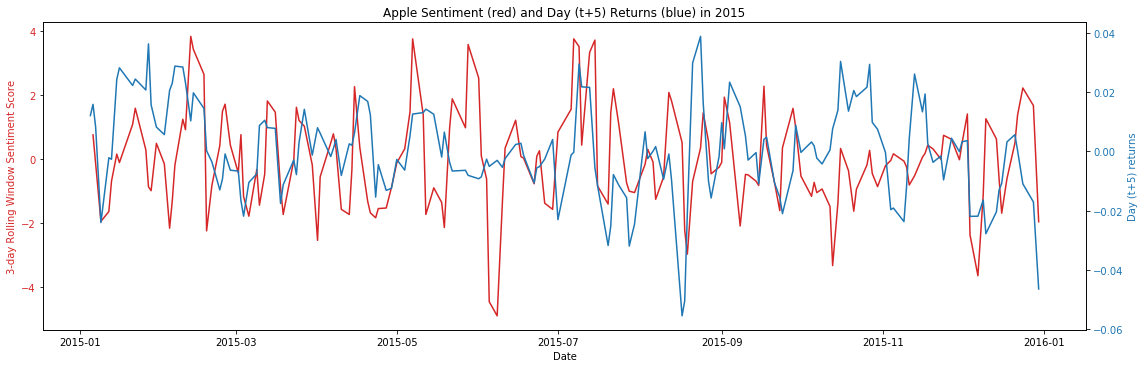

In [4]:
temp = aapl_df[aapl_df['Year']==2015]

# 2015
## Plot vader sentiment against returns (t+5)
fig, ax1 = plt.subplots(figsize=(16,5))
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('3-day Rolling Window Sentiment Score', color=color)
ax1.plot(temp["Date"].dt.date.tolist(), temp['vader3'], color=color)
#plt.xticks(np.arange(1, 53, 1))
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Day (t+5) returns', color=color)  # we already handled the x-label with ax1
ax2.plot(temp["Date"].dt.date.tolist(), temp['returns5'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Apple Sentiment (red) and Day (t+5) Returns (blue) in 2015")
plt.show()

## 3. Correlation between feature engineered features (and return5)

In [5]:
filter_df = aapl_df[['vader3', 'likes', 'replies', 'totalEmoticons',\
                     'totalSlangs', 'totalElongated',\
                     'totalMultiExclamationMarks', 'totalMultiQuestionMarks',\
                     'totalMultiStopMarks', 'returns5', 'hist_returns']]
filter_df.describe()

,vader3,likes,replies,totalEmoticons,totalSlangs,totalElongated,totalMultiExclamationMarks,totalMultiQuestionMarks,totalMultiStopMarks,returns5,hist_returns
count,1623.000000,1631.000000,1631.000000,1631.000000,1631.000000,1631.000000,1631.000000,1631.000000,1631.000000,1631.000000,1631.000000
mean,-0.300762,46.057633,6.460454,13.342121,6.311465,1.139792,1.293685,0.312692,9.811159,0.001853,0.000306
std,1.505489,362.234748,27.971142,44.112023,21.367508,3.917095,4.099254,1.198805,33.198897,0.015948,0.007190
min,-6.347269,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.055436,-0.057277
25%,-1.304356,1.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-0.007811,-0.003125
50%,-0.349927,4.000000,1.000000,5.000000,2.000000,0.000000,0.000000,0.000000,4.000000,0.002502,0.000376
75%,0.642052,13.000000,3.000000,8.000000,4.000000,1.000000,1.000000,0.000000,6.000000,0.011863,0.004218
max,4.493038,11769.000000,559.000000,538.000000,253.000000,52.000000,56.000000,16.000000,416.000000,0.057346,0.034220


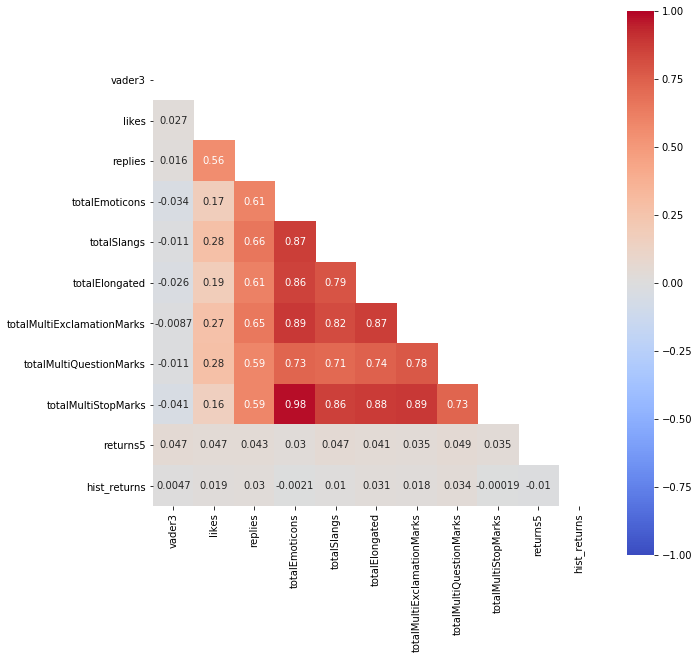

In [6]:
corr = filter_df.corr()
# corr.style.background_gradient(cmap='coolwarm', axis=None)
fig, ax = plt.subplots(figsize=(10,10))  
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, cmap='coolwarm', mask=mask, annot=True, vmin=-1, vmax=1, center= 0, square=True)

In [7]:
corr.min()

vader3                       -0.041198
likes                         0.018566
replies                       0.016149
totalEmoticons               -0.033976
totalSlangs                  -0.010639
totalElongated               -0.026171
totalMultiExclamationMarks   -0.008740
totalMultiQuestionMarks      -0.011095
totalMultiStopMarks          -0.041198
returns5                     -0.010363
hist_returns                 -0.010363
dtype: float64

## 4. Wordcloud from tokens

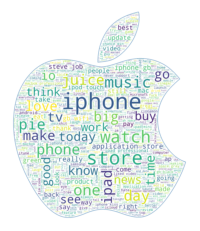

In [9]:
# Read the whole text.
text = ' '.join(aapl_df['tokenized_tweet'].str.join(' '))

# read the mask image
alice_mask = np.array(Image.open('../../Raw Data/Tweets/Other Sources/apple.png'))

stopwords = set(STOPWORDS)
stopwords = ["apple", "new", "rt", "got", 'via', 'want', 'need'] + list(STOPWORDS)

wc = WordCloud(background_color="white", max_words=2000, mask=alice_mask,
               stopwords=stopwords, contour_width=3, contour_color='steelblue')

# generate word cloud
wc.generate(text)

# store to file
# wc.to_file("C:/Users/jasmine/Desktop/NUS Modules/BT4222/Project/apple_cloud.png")

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [10]:
nike_df = pd.read_pickle("../../Processed Data/Tweets/NKE_df.pkl")
nike_df = nike_df[(nike_df['tokenized_tweet'].notnull())].reset_index()


[MASK] Image detected in the same directory. Plotting wordcloud with mask


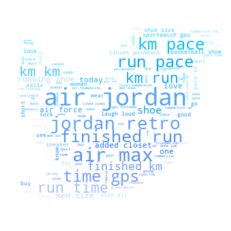

In [11]:
# Read the whole text.
text = ' '.join(nike_df['tokenized_tweet'].str.join(' '))

# read the mask image
# alice_mask = np.array(Image.open('C:/Users/jasmine/Desktop/NUS Modules/BT4222/Project/tweet.png'))

stopwords = set(STOPWORDS)
stopwords = ["nike", "new", "rt", "got", 'via', 'want', 'need', 'mi', 'ran'] + list(STOPWORDS)

print('[MASK] Image detected in the same directory. Plotting wordcloud with mask')
mask = np.array(imageio.imread('../../Raw Data/Tweets/Other Sources/tweet.jpg'))
image_colors = ImageColorGenerator(mask)
cloud = WordCloud(background_color="white", 
                  mask=mask,
                  color_func = image_colors,
                  stopwords=stopwords,
                 ).generate(text)

# store to file
# cloud.to_file("C:/Users/jasmine/Desktop/NUS Modules/BT4222/Project/nike.png")

# show
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Feature Engineering

In [11]:
def train_test_split(df):
    '''
    Split data into train-test set, according to date.
    Train set: 2010 to 2017
    Test set: 2018 to 2019
    
    Parameters
    ----------
        df         (pandas DataFrame)
        
    Returns
    -------
        the 2 pandas DataFrames, train and test df
    '''
    
    # Split chronologically
    df_train = df[df['Year']<=2017].dropna(subset=['text','vader3'])
    df_test = df[df['Year']>2017].dropna(subset=['text','vader3'])
    print("Train size:", df_train.shape)
    print("Test size:", df_test.shape)
    
    return df_train, df_test

def dummy(doc):
    '''
    Dummy function for CountVectorizer, to allow list of tokens as input.
    
    Parameters
    ----------
        doc      (object)
        
    Returns
    -------
        object
    '''
    return doc
cv = CountVectorizer(tokenizer=dummy, preprocessor=dummy)

def vectorise(df, is_train): 
    '''
    Vectorise text column using CountVectorizer method.
    Concat historical returns and vader sentiment to sparse matrix.
    
    Parameters
    ----------
        df           (pandas DataFrame)
        is_train     (boolean) if df is train or test set
        
    Returns
    -------
        sparse matrix of vectorised tokens
    '''

    X = df['tokenized_tweet']
#     y = df['label5'] # predicts returns 1 week later

    print("Vectorising tokens...")
    # ------ Vectorise text tokens ------    
    if is_train:
        X_dtm = cv.fit_transform(X)
    else:
        X_dtm = cv.transform(X)
    print("Size after vectorise:", X_dtm.shape)
    
    X_dtm = hstack((X_dtm,np.array(df[['hist_returns', 'vader3']])))
    print("Size after stack:", X_dtm.shape)
    
    return X_dtm
    
def oversample(X_dtm, y):
    '''
    Oversample minority class using random sampling.
    
    Parameters
    ----------
        x_dtm        (scipy sparse matrix)
        y            (pandas Series) 
        
    Returns
    -------
        pandas DataFrame of X_train, and pandas series of y labels
    '''
    print("Oversampling train set...")
    # ------ Oversampling ------
    df_train = pd.DataFrame(X_dtm.todense())
    print(df_train.shape, y.shape)
    df_train['target'] = np.array(y)
    
    print('Before over-sampling:')
    print(df_train.target.value_counts())
    
    # Class count
    count_class_up, count_class_down = df_train.target.value_counts()
    # Divide by class
    df_class_down = df_train[df_train['target'] == -1]
    df_class_up = df_train[df_train['target'] == 1]

    df_class_down = df_class_down.sample(count_class_up, replace=True)
    df_train = pd.concat([df_class_up, df_class_down], axis=0)

    print('After over-sampling:')
    print(df_train.target.value_counts())
    
    y = df_train['target']
    X_dtm = df_train.drop('target', axis=1)
    
    return X_dtm, y

# Modelling

In [12]:
# Remove 5 companies: CAT, DIS, DOW, TRV, WBA
ticker_symbol = ["MMM", "AXP", "AAPL", "BA", \
                 "CVX", "CSCO", "KO", "XOM", \
                 "GS", "HD", "IBM", "INTC", \
                 "JNJ", "JPM", "MCD", \
                 "MRK", "MSFT", "NKE", "PFE", \
                 "PG",  "UTX", "UNH", 
                 "VZ", "V", "WMT"]

performance = {}

RFC = RandomForestClassifier(n_jobs=7,verbose=1,oob_score=True,
                                     random_state=42, n_estimators=200, 
                                     max_depth=150, max_features='log2')

for symb in ticker_symbol:
    print("Company:", symb)
    df = pd.read_pickle("../../Processed Data/Tweets/" +symb+ "_df.pkl").reset_index(drop=True)
    
    # ----- Train-Test Split ------
    df_train, df_test = train_test_split(df)
    
    # ----- Vectorise X Data ------
    X_train_dtm = vectorise(df_train, is_train=True)
    X_test_dtm = vectorise(df_test, is_train=False)
    y_train = df_train['label5']
    y_test = df_test['label5']
    
    # ----- Oversample Train Set ------
    X_train_dtm_over, y_train_over = oversample(X_train_dtm, y_train)
    
    # ----- Fit & Predict Model ------
    RFC.fit(X_train_dtm_over, y_train_over)
    y_pred_train = RFC.predict(X_train_dtm)
    y_pred_test = RFC.predict(X_test_dtm)
    
    # ----- Evaluate Model ------
    # Get the training accuracy
    print('Training Accuracy: ', metrics.accuracy_score(y_train, y_pred_train))
    # print the accuracy of its predictions
    print('Test Accuracy: ', metrics.accuracy_score(y_test, y_pred_test))
    print('Number of Ups:', len(y_pred_test[y_pred_test==1]))
    print('% of Downs:', len(y_pred_test[y_pred_test!=1])/len(y_pred_test))
    
    acc = metrics.accuracy_score(y_test, y_pred_test)
    f1 = metrics.f1_score(y_test, y_pred_test)
    recall = metrics.recall_score(y_test, y_pred_test)
    precision = metrics.precision_score(y_test, y_pred_test)
    performance[symb] = [acc, f1, recall, precision]
    
    # ----- Generate predictions.csv ------
    predict_train = pd.concat([df_train['Date'].reset_index(drop=True), 
                               pd.DataFrame(y_pred_train, columns=[symb])], axis=1)
    predict_test = pd.concat([df_test['Date'].reset_index(drop=True),
                              pd.DataFrame(y_pred_test, columns=[symb])], axis=1)
    
    predict_train = df[df['Year']<=2017][['Date']].join(predict_train.set_index('Date'), on='Date', how='left')
    predict_train[symb] = predict_train[symb].ffill(limit=4).fillna(0)
    predict_test = df[df['Year']>2017][['Date']].join(predict_test.set_index('Date'), on='Date', how='left')
    predict_test[symb] = predict_test[symb].ffill(limit=4).fillna(0)
    
    predict_train.to_csv("../../Predictions/Tweets/" +symb+ "_train_tweet.csv")
    predict_test.to_csv("../../Predictions/Tweets/" +symb+ "_test_tweet.csv")

Company: MMM
Train size: (1441, 24)
Test size: (362, 24)
Vectorising tokens...
Size after vectorise: (1441, 43165)
Size after stack: (1441, 43167)
Vectorising tokens...
Size after vectorise: (362, 43165)
Size after stack: (362, 43167)
Oversampling train set...
(1441, 43167) (1441,)
Before over-sampling:
 1    843
-1    598
Name: target, dtype: int64
After over-sampling:
 1    843
-1    843
Name: target, dtype: int64


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.7s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    4.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished


Training Accuracy:  0.8993754337265788
Test Accuracy:  0.5469613259668509
Number of Ups: 360
% of Downs: 0.0055248618784530384
Company: AXP
Train size: (1449, 24)
Test size: (373, 24)
Vectorising tokens...
Size after vectorise: (1449, 26696)
Size after stack: (1449, 26698)
Vectorising tokens...
Size after vectorise: (373, 26696)
Size after stack: (373, 26698)
Oversampling train set...
(1449, 26698) (1449,)
Before over-sampling:
 1    816
-1    633
Name: target, dtype: int64
After over-sampling:
 1    816
-1    816
Name: target, dtype: int64


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.6s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    3.1s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    3.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished


Training Accuracy:  0.8951000690131125
Test Accuracy:  0.5951742627345844
Number of Ups: 366
% of Downs: 0.01876675603217158
Company: AAPL
Train size: (1441, 24)
Test size: (362, 24)
Vectorising tokens...
Size after vectorise: (1441, 44903)
Size after stack: (1441, 44905)
Vectorising tokens...
Size after vectorise: (362, 44903)
Size after stack: (362, 44905)
Oversampling train set...
(1441, 44905) (1441,)
Before over-sampling:
 1    816
-1    625
Name: target, dtype: int64
After over-sampling:
 1    816
-1    816
Name: target, dtype: int64


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.6s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    3.5s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    3.8s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished


Training Accuracy:  0.8841082581540597
Test Accuracy:  0.6270718232044199
Number of Ups: 362
% of Downs: 0.0
Company: BA
Train size: (1441, 24)
Test size: (362, 24)
Vectorising tokens...
Size after vectorise: (1441, 66784)
Size after stack: (1441, 66786)
Vectorising tokens...
Size after vectorise: (362, 66784)
Size after stack: (362, 66786)
Oversampling train set...
(1441, 66786) (1441,)
Before over-sampling:
 1    829
-1    612
Name: target, dtype: int64
After over-sampling:
 1    829
-1    829
Name: target, dtype: int64


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    1.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    5.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    5.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished


Training Accuracy:  0.9000693962526024
Test Accuracy:  0.5276243093922652
Number of Ups: 360
% of Downs: 0.0055248618784530384
Company: CVX
Train size: (1453, 24)
Test size: (362, 24)
Vectorising tokens...
Size after vectorise: (1453, 45872)
Size after stack: (1453, 45874)
Vectorising tokens...
Size after vectorise: (362, 45872)
Size after stack: (362, 45874)
Oversampling train set...
(1453, 45874) (1453,)
Before over-sampling:
 1    819
-1    634
Name: target, dtype: int64
After over-sampling:
 1    819
-1    819
Name: target, dtype: int64


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.7s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    3.5s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    3.7s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished


Training Accuracy:  0.8912594631796283
Test Accuracy:  0.5193370165745856
Number of Ups: 358
% of Downs: 0.011049723756906077
Company: CSCO
Train size: (1443, 24)
Test size: (362, 24)
Vectorising tokens...
Size after vectorise: (1443, 46152)
Size after stack: (1443, 46154)
Vectorising tokens...
Size after vectorise: (362, 46152)
Size after stack: (362, 46154)
Oversampling train set...
(1443, 46154) (1443,)
Before over-sampling:
 1    830
-1    613
Name: target, dtype: int64
After over-sampling:
 1    830
-1    830
Name: target, dtype: int64


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.8s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    4.2s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    4.5s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished


Training Accuracy:  0.8988218988218988
Test Accuracy:  0.5662983425414365
Number of Ups: 344
% of Downs: 0.049723756906077346
Company: KO
Train size: (1441, 24)
Test size: (362, 24)
Vectorising tokens...
Size after vectorise: (1441, 65865)
Size after stack: (1441, 65867)
Vectorising tokens...
Size after vectorise: (362, 65865)
Size after stack: (362, 65867)
Oversampling train set...
(1441, 65867) (1441,)
Before over-sampling:
 1    835
-1    606
Name: target, dtype: int64
After over-sampling:
 1    835
-1    835
Name: target, dtype: int64


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.8s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    4.5s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished


Training Accuracy:  0.8827203331020125
Test Accuracy:  0.6022099447513812
Number of Ups: 362
% of Downs: 0.0
Company: XOM
Train size: (1526, 24)
Test size: (382, 24)
Vectorising tokens...
Size after vectorise: (1526, 25890)
Size after stack: (1526, 25892)
Vectorising tokens...
Size after vectorise: (382, 25890)
Size after stack: (382, 25892)
Oversampling train set...
(1526, 25892) (1526,)
Before over-sampling:
 1    844
-1    682
Name: target, dtype: int64
After over-sampling:
 1    844
-1    844
Name: target, dtype: int64


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.4s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    2.5s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    2.7s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished


Training Accuracy:  0.8787680209698558
Test Accuracy:  0.5052356020942408
Number of Ups: 378
% of Downs: 0.010471204188481676
Company: GS
Train size: (1456, 24)
Test size: (368, 24)
Vectorising tokens...
Size after vectorise: (1456, 33829)
Size after stack: (1456, 33831)
Vectorising tokens...
Size after vectorise: (368, 33829)
Size after stack: (368, 33831)
Oversampling train set...
(1456, 33831) (1456,)
Before over-sampling:
 1    793
-1    663
Name: target, dtype: int64
After over-sampling:
 1    793
-1    793
Name: target, dtype: int64


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.5s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    3.4s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    3.7s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished


Training Accuracy:  0.8722527472527473
Test Accuracy:  0.5489130434782609
Number of Ups: 348
% of Downs: 0.05434782608695652
Company: HD
Train size: (1441, 24)
Test size: (364, 24)
Vectorising tokens...
Size after vectorise: (1441, 44047)
Size after stack: (1441, 44049)
Vectorising tokens...
Size after vectorise: (364, 44047)
Size after stack: (364, 44049)
Oversampling train set...
(1441, 44049) (1441,)
Before over-sampling:
 1    868
-1    573
Name: target, dtype: int64
After over-sampling:
 1    868
-1    868
Name: target, dtype: int64


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.7s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    3.7s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    3.9s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished


Training Accuracy:  0.9146426092990978
Test Accuracy:  0.5247252747252747
Number of Ups: 363
% of Downs: 0.0027472527472527475
Company: IBM
Train size: (1441, 24)
Test size: (362, 24)
Vectorising tokens...
Size after vectorise: (1441, 41978)
Size after stack: (1441, 41980)
Vectorising tokens...
Size after vectorise: (362, 41978)
Size after stack: (362, 41980)
Oversampling train set...
(1441, 41980) (1441,)
Before over-sampling:
 1    768
-1    673
Name: target, dtype: int64
After over-sampling:
 1    768
-1    768
Name: target, dtype: int64


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.5s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    2.8s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    3.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished


Training Accuracy:  0.8487161693268563
Test Accuracy:  0.5359116022099447
Number of Ups: 348
% of Downs: 0.03867403314917127
Company: INTC
Train size: (1441, 24)
Test size: (362, 24)
Vectorising tokens...
Size after vectorise: (1441, 44574)
Size after stack: (1441, 44576)
Vectorising tokens...
Size after vectorise: (362, 44574)
Size after stack: (362, 44576)
Oversampling train set...
(1441, 44576) (1441,)
Before over-sampling:
 1    804
-1    637
Name: target, dtype: int64
After over-sampling:
 1    804
-1    804
Name: target, dtype: int64


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.6s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    3.4s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    3.7s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished


Training Accuracy:  0.8723108952116586
Test Accuracy:  0.580110497237569
Number of Ups: 362
% of Downs: 0.0
Company: JNJ
Train size: (1441, 24)
Test size: (362, 24)
Vectorising tokens...
Size after vectorise: (1441, 61561)
Size after stack: (1441, 61563)
Vectorising tokens...
Size after vectorise: (362, 61561)
Size after stack: (362, 61563)
Oversampling train set...
(1441, 61563) (1441,)
Before over-sampling:
 1    819
-1    622
Name: target, dtype: int64
After over-sampling:
 1    819
-1    819
Name: target, dtype: int64


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.7s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    4.4s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    4.6s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished


Training Accuracy:  0.878556557945871
Test Accuracy:  0.5497237569060773
Number of Ups: 358
% of Downs: 0.011049723756906077
Company: JPM
Train size: (1493, 24)
Test size: (375, 24)
Vectorising tokens...
Size after vectorise: (1493, 27531)
Size after stack: (1493, 27533)
Vectorising tokens...
Size after vectorise: (375, 27531)
Size after stack: (375, 27533)
Oversampling train set...
(1493, 27533) (1493,)
Before over-sampling:
 1    857
-1    636
Name: target, dtype: int64
After over-sampling:
 1    857
-1    857
Name: target, dtype: int64


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.5s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    2.6s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    2.7s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished


Training Accuracy:  0.8941728064300067
Test Accuracy:  0.568
Number of Ups: 375
% of Downs: 0.0
Company: MCD
Train size: (1441, 24)
Test size: (362, 24)
Vectorising tokens...
Size after vectorise: (1441, 48007)
Size after stack: (1441, 48009)
Vectorising tokens...
Size after vectorise: (362, 48007)
Size after stack: (362, 48009)
Oversampling train set...
(1441, 48009) (1441,)
Before over-sampling:
 1    874
-1    567
Name: target, dtype: int64
After over-sampling:
 1    874
-1    874
Name: target, dtype: int64


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.7s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    4.2s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished


Training Accuracy:  0.922970159611381
Test Accuracy:  0.5524861878453039
Number of Ups: 355
% of Downs: 0.019337016574585635
Company: MRK
Train size: (1461, 24)
Test size: (368, 24)
Vectorising tokens...
Size after vectorise: (1461, 49149)
Size after stack: (1461, 49151)
Vectorising tokens...
Size after vectorise: (368, 49149)
Size after stack: (368, 49151)
Oversampling train set...
(1461, 49151) (1461,)
Before over-sampling:
 1    777
-1    684
Name: target, dtype: int64
After over-sampling:
 1    777
-1    777
Name: target, dtype: int64


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.6s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    3.3s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    3.6s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished


Training Accuracy:  0.8473648186173853
Test Accuracy:  0.6059782608695652
Number of Ups: 360
% of Downs: 0.021739130434782608
Company: MSFT
Train size: (1441, 24)
Test size: (362, 24)
Vectorising tokens...
Size after vectorise: (1441, 40222)
Size after stack: (1441, 40224)
Vectorising tokens...
Size after vectorise: (362, 40222)
Size after stack: (362, 40224)
Oversampling train set...
(1441, 40224) (1441,)
Before over-sampling:
 1    830
-1    611
Name: target, dtype: int64
After over-sampling:
 1    830
-1    830
Name: target, dtype: int64


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.6s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    3.2s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    3.4s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished


Training Accuracy:  0.8924358084663429
Test Accuracy:  0.6187845303867403
Number of Ups: 349
% of Downs: 0.03591160220994475
Company: NKE
Train size: (1441, 24)
Test size: (362, 24)
Vectorising tokens...
Size after vectorise: (1441, 36498)
Size after stack: (1441, 36500)
Vectorising tokens...
Size after vectorise: (362, 36498)
Size after stack: (362, 36500)
Oversampling train set...
(1441, 36500) (1441,)
Before over-sampling:
 1    811
-1    630
Name: target, dtype: int64
After over-sampling:
 1    811
-1    811
Name: target, dtype: int64


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.6s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    3.3s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    3.6s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished


Training Accuracy:  0.8834142956280361
Test Accuracy:  0.5939226519337016
Number of Ups: 356
% of Downs: 0.016574585635359115
Company: PFE
Train size: (1465, 24)
Test size: (369, 24)
Vectorising tokens...
Size after vectorise: (1465, 38579)
Size after stack: (1465, 38581)
Vectorising tokens...
Size after vectorise: (369, 38579)
Size after stack: (369, 38581)
Oversampling train set...
(1465, 38581) (1465,)
Before over-sampling:
 1    794
-1    671
Name: target, dtype: int64
After over-sampling:
 1    794
-1    794
Name: target, dtype: int64


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.5s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    3.1s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    3.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished


Training Accuracy:  0.8784982935153584
Test Accuracy:  0.5799457994579946
Number of Ups: 354
% of Downs: 0.04065040650406504
Company: PG
Train size: (1498, 24)
Test size: (362, 24)
Vectorising tokens...
Size after vectorise: (1498, 23439)
Size after stack: (1498, 23441)
Vectorising tokens...
Size after vectorise: (362, 23439)
Size after stack: (362, 23441)
Oversampling train set...
(1498, 23441) (1498,)
Before over-sampling:
 1    837
-1    661
Name: target, dtype: int64
After over-sampling:
 1    837
-1    837
Name: target, dtype: int64


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.4s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    2.3s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    2.5s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished


Training Accuracy:  0.8845126835781041
Test Accuracy:  0.6132596685082873
Number of Ups: 357
% of Downs: 0.013812154696132596
Company: UTX
Train size: (1510, 24)
Test size: (362, 24)
Vectorising tokens...
Size after vectorise: (1510, 29895)
Size after stack: (1510, 29897)
Vectorising tokens...
Size after vectorise: (362, 29895)
Size after stack: (362, 29897)
Oversampling train set...
(1510, 29897) (1510,)
Before over-sampling:
 1    870
-1    640
Name: target, dtype: int64
After over-sampling:
 1    870
-1    870
Name: target, dtype: int64


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.4s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    2.7s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    2.9s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished


Training Accuracy:  0.9019867549668874
Test Accuracy:  0.5580110497237569
Number of Ups: 361
% of Downs: 0.0027624309392265192
Company: UNH
Train size: (1457, 24)
Test size: (373, 24)
Vectorising tokens...
Size after vectorise: (1457, 41774)
Size after stack: (1457, 41776)
Vectorising tokens...
Size after vectorise: (373, 41774)
Size after stack: (373, 41776)
Oversampling train set...
(1457, 41776) (1457,)
Before over-sampling:
 1    858
-1    599
Name: target, dtype: int64
After over-sampling:
 1    858
-1    858
Name: target, dtype: int64


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.7s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    3.5s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    3.7s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished


Training Accuracy:  0.9032258064516129
Test Accuracy:  0.5764075067024129
Number of Ups: 368
% of Downs: 0.013404825737265416
Company: VZ
Train size: (1441, 24)
Test size: (362, 24)
Vectorising tokens...
Size after vectorise: (1441, 36845)
Size after stack: (1441, 36847)
Vectorising tokens...
Size after vectorise: (362, 36845)
Size after stack: (362, 36847)
Oversampling train set...
(1441, 36847) (1441,)
Before over-sampling:
 1    809
-1    632
Name: target, dtype: int64
After over-sampling:
 1    809
-1    809
Name: target, dtype: int64


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.5s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    3.2s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    3.4s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished


Training Accuracy:  0.8861901457321305
Test Accuracy:  0.5386740331491713
Number of Ups: 340
% of Downs: 0.06077348066298342
Company: V
Train size: (1441, 24)
Test size: (362, 24)
Vectorising tokens...
Size after vectorise: (1441, 51070)
Size after stack: (1441, 51072)
Vectorising tokens...
Size after vectorise: (362, 51070)
Size after stack: (362, 51072)
Oversampling train set...
(1441, 51072) (1441,)
Before over-sampling:
 1    840
-1    601
Name: target, dtype: int64
After over-sampling:
 1    840
-1    840
Name: target, dtype: int64


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.7s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    4.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished


Training Accuracy:  0.9028452463566967
Test Accuracy:  0.643646408839779
Number of Ups: 359
% of Downs: 0.008287292817679558
Company: WMT
Train size: (1442, 24)
Test size: (366, 24)
Vectorising tokens...
Size after vectorise: (1442, 46994)
Size after stack: (1442, 46996)
Vectorising tokens...
Size after vectorise: (366, 46994)
Size after stack: (366, 46996)
Oversampling train set...
(1442, 46996) (1442,)
Before over-sampling:
 1    804
-1    638
Name: target, dtype: int64
After over-sampling:
 1    804
-1    804
Name: target, dtype: int64


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.8s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    3.9s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    4.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished


Training Accuracy:  0.875866851595007
Test Accuracy:  0.5601092896174863
Number of Ups: 364
% of Downs: 0.00546448087431694


# Visualise Model Results

## 1. Heatmap of Model Performance Across All Models

In [27]:
metrics_df = pd.DataFrame(performance).T
metrics_df = metrics_df.rename(columns={0:"accuracy", 1:"f1", 2:"recall", 3:"precision"}).sort_index()

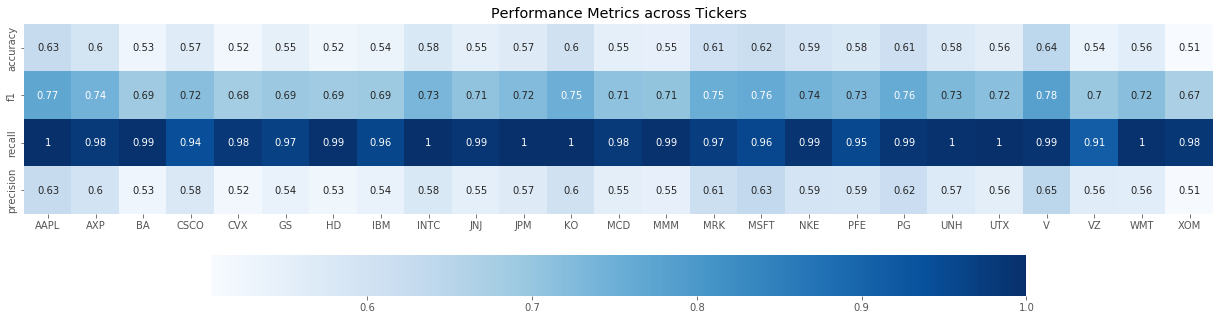

In [29]:
plt.style.use('ggplot')
%matplotlib inline
plt.figure(figsize=(30,5))
sns.heatmap(metrics_df.T, square=True,annot=True,cmap="Blues", linecolor='white',
            cbar_kws = dict(use_gridspec=False,location="bottom"))
plt.title('Performance Metrics across Tickers')
plt.yticks(va="center")

plt.show()

## 2. Feature Importance of AAPL Model via SHAP 

In [17]:
df = pd.read_pickle("../../Processed Data/Tweets/AAPL_df.pkl").reset_index(drop=True)

# ----- Train-Test Split ------
df_train, df_test = train_test_split(df)

# ----- Vectorise X Data ------
X_train_dtm = vectorise(df_train, is_train=True)
X_test_dtm = vectorise(df_test, is_train=False)
y_train = df_train['label5']
y_test = df_test['label5']

# ----- Oversample Train Set ------
X_train_dtm_over, y_train_over = oversample(X_train_dtm, y_train)

# ----- Fit & Predict Model ------
RFC.fit(X_train_dtm_over, y_train_over)
y_pred_train = RFC.predict(X_train_dtm)
y_pred_test = RFC.predict(X_test_dtm)

Train size: (1441, 24)
Test size: (362, 24)
Vectorising tokens...
Size after vectorise: (1441, 44903)
Size after stack: (1441, 44905)
Vectorising tokens...
Size after vectorise: (362, 44903)
Size after stack: (362, 44905)
Oversampling train set...
(1441, 44905) (1441,)
Before over-sampling:
 1    816
-1    625
Name: target, dtype: int64
After over-sampling:
 1    816
-1    816
Name: target, dtype: int64


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.3s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    1.7s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    1.8s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 200 out of 200 | elapsed:    0.0s finished


In [18]:
shap.initjs()
import shap, time


t0 = time.time()
explainer = shap.TreeExplainer(RFC)
shap_values_test = explainer.shap_values(X_test_dtm.todense(), approximate=True)
t1 = time.time()
timeit = t1-t0
print('time to compute Shapley values (s):', timeit)

col_names = cv.get_feature_names()+['hist_returns', 'vader']
txt_dense_df = pd.DataFrame(X_test_dtm.todense(), columns=col_names)
shap_values_test_df = pd.DataFrame(shap_values_test[0], columns=txt_dense_df.columns)

shap_sum = np.abs(shap_values_test_df).mean(axis=0)

importance_df = pd.DataFrame([txt_dense_df.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ["column_name", "shap_importance (log-odds)"]
importance_df = importance_df.sort_values('shap_importance (log-odds)', ascending=False)
importance_df['shap_importance (%)'] = importance_df['shap_importance (log-odds)'].apply(lambda x: 100 *x/np.sum(importance_df['shap_importance (log-odds)']))


topN = 20
top20 = importance_df.iloc[0:topN]["column_name"]

print('Cumulative Importance', np.sum(importance_df.iloc[0:topN]["shap_importance (%)"]))

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


time to compute Shapley values (s): 0.9618897438049316
Cumulative Importance 3.6483081816604175


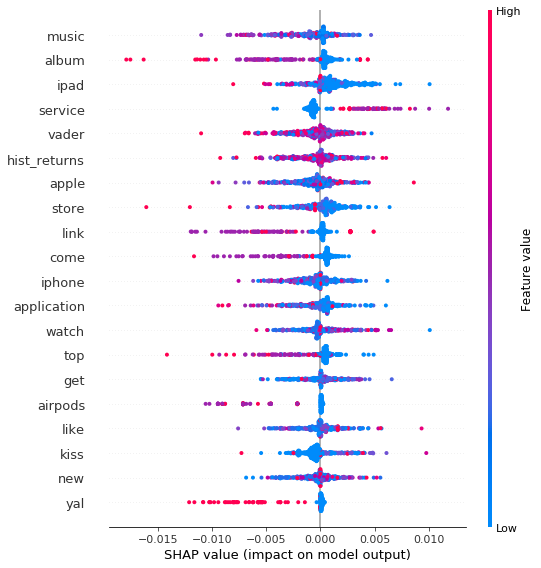

In [19]:
shap.summary_plot(shap_values_test[0], txt_dense_df)

In [20]:
shap.initjs()

shap_values_imp = shap_values_test_df[top20]
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value[0], shap_values_imp.iloc[17].to_numpy(), 
                txt_dense_df.iloc[17][top20])